# SFigure 10 -- Identify gradients/hierarchies using non-negative matrix factorization

In [3]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nilearn.plotting as plotting
from importlib import reload
import wbplot
import pandas as pd
import matplotlib.image as img 
import os
import h5py
import matplotlib.colors as clrs
from matplotlib import colorbar
plt.rcParams['font.sans-serif'] = "Arial"
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.sandbox.stats.multicomp as mc
import bct
import scipy
import statsmodels.formula.api as smf

from brainsmash.mapgen.base import Base
from brainsmash.mapgen.stats import pearsonr, pairwise_r
from brainsmash.mapgen.stats import nonparp

#### Set up basic parameters

In [4]:
figuredir = '../figures/SFig10/'
if not os.path.exists(figuredir): os.makedirs(figuredir)

networkdef = np.loadtxt('cortex_parcel_network_assignments.txt')
# need to subtract one to make it compatible for python indices
indsort = np.loadtxt('cortex_community_order.txt',dtype=int) - 1 
indsort.shape = (len(indsort),1)

# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[indsort]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)
parcel_network_palette = []
for roi in range(nParcels): parcel_network_palette.append(networkpalette[int(networkdef[roi]-1)])

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

glasserfilename = 'Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = np.squeeze(nib.load(glasserfilename).get_fdata())

#### split up sensorimotor from association network color palettes
color1, color2 = sns.color_palette(palette='Pastel1')[1], sns.color_palette(palette='Pastel1')[0]
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']

roi_id = np.zeros((nParcels,))
tmp = {}
netcount = 0
for network in networkmappings:
    net = np.where(networkdef==networkmappings[network])[0]
    for roi in net:
        if network in associationnets:
            tmp[roi] = color1 #'r'
            roi_id[roi] = -1
        else:
            tmp[roi] = color2 #'b'
            roi_id[roi] = 1
    netcount += 1
    
roiColorsByNetwork = []
for roi in range(len(networkdef)):
    roiColorsByNetwork.append(tmp[roi])
    
    
subIDs = ['02','03','04','06','08','09','10','12','14','15','18','20','22','25','27','29','31','17','19','21','24','26','28','30']
sub_with_rest = ['02','03','06','08','10','12','14','18','20','22','24','25','26','27','28','29','30','31'] 

# Load multi-task representational dimensionality and margulies gradients

In [5]:
df_dim = pd.read_csv('../processed_data/analysis1/analysis1_parcel_cosine_dimensionality.csv')
avg_dim = []
for i in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    avg_dim.append(df_dim.Dimensionality[df_dim.Parcels==i+1].mean())
avg_dim = np.asarray(avg_dim)


# Gradient 1

In [6]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
# ListedColormap(colormap.colors[::-1])

newcmp = ListedColormap(newcolors[::-1], name='OrangeBlue')

parcellated_gradients = np.loadtxt('../processed_data/analysis1/analysis1_restFC_gradients.csv')


# Load and visualize representational distance

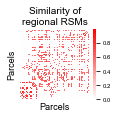

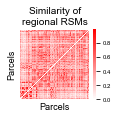

In [7]:
distance = 'cosine'
rep_dist_mat = np.loadtxt('../processed_data/analysis1/analysis1_cosine_interregion_representational_distances_cosineRSMs.csv')
rep_dist_mat_unthresh = np.loadtxt('../processed_data/analysis1/analysis1_cosine_interregion_representational_distances_cosineRSMs_unthresholded.csv')
# np.fill_diagonal(rep_dist_mat,0)
sorted_mat = rep_dist_mat[indsort,indsort.T]
plt.figure(figsize=(1.75,1.75))
# plt.subplot(121)
ax = sns.heatmap(sorted_mat,center=0,cmap='bwr',square=True,cbar_kws={'fraction':0.046})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=6)
plt.xlabel("Parcels",fontsize=9);
plt.ylabel("Parcels",fontsize=9);
plt.title('Similarity of\nregional RSMs',fontsize=10)
plt.xticks([]);
plt.yticks([]);
ax.invert_yaxis()
plt.tight_layout()

#
plt.figure(figsize=(1.75,1.75))
# plt.subplot(122)
sorted_mat = rep_dist_mat_unthresh[indsort,indsort.T]
ax = sns.heatmap(sorted_mat,center=0,cmap='bwr',square=True,cbar_kws={'fraction':0.046})
plt.xlabel("Parcels",fontsize=9);
plt.ylabel("Parcels",fontsize=9);
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=6)
plt.title('Similarity of\nregional RSMs',fontsize=10)
plt.xticks([]);
plt.yticks([]);
ax.invert_yaxis()
plt.tight_layout()


# Compute Non-negative matrix factorization

In [8]:
from sklearn.decomposition import NMF

model = NMF(n_components=2,init='random',max_iter=500)
W = model.fit_transform(rep_dist_mat_unthresh)
nmf_gradients = model.components_.T

stats.pearsonr(nmf_gradients[:,0],parcellated_gradients[:,1])

(0.6239390990819491, 3.096552392055183e-40)

#### Visualize NMF 'gradients'

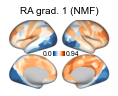

In [10]:
# Run wbplot
vrange = 2
if not os.path.exists(figuredir + 'RA_Gradient_NMF.png'):
    tmp = np.hstack((nmf_gradients[180:,0],nmf_gradients[:180,0]))
    tmp = stats.zscore(tmp)
    wbplot.pscalar(figuredir + 'RA_Gradient_NMF.png',tmp,vrange=(-vrange,vrange),cmap=newcmp)


fig = plt.figure(figsize=(1.75,1.75))
ax = plt.subplot(1,1,1)
im = img.imread(figuredir + 'RA_Gradient_NMF.png') 
plt.imshow(im)
plt.axis('off')
plt.title('RA grad. 1 (NMF)',fontsize=10)
vmin, vmax = np.min(tmp), np.max(tmp)
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = newcmp
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(np.min(nmf_gradients[:,0]),2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
cax.text(1.025, 0.4, str(round(np.max(nmf_gradients[:,0]),2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
plt.tight_layout()
plt.savefig(figuredir + 'RAGradientSurface_NMF.png',dpi=300,transparent=True)

#### Load and visualize on surface the gradients of representational distance matrix

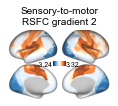

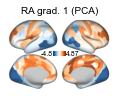

In [13]:
rsm_gradients = np.loadtxt('../processed_data/analysis1/analysis1_cosine_3components_cosineRSMs_representational_gradients.csv')

vrange = 2
if not os.path.exists(figuredir + 'Parcellated_InterRegionalRepSimilarity.png'):
    tmp = np.hstack((rsm_gradients[180:,0],rsm_gradients[:180,0]))
    tmp = stats.zscore(tmp)
    wbplot.pscalar(figuredir + 'Parcellated_InterRegionalRepSimilarity.png',tmp,vrange=(-vrange,vrange),cmap=newcmp)

if not os.path.exists(figuredir + 'Parcellated_MarguliesGradient2.png'):
    tmp = np.hstack((parcellated_gradients[180:,1],parcellated_gradients[:180,1]))
    tmp = stats.zscore(tmp)
    wbplot.pscalar(figuredir + 'Parcellated_MarguliesGradient2.png',tmp,vrange=(-vrange,vrange),cmap=newcmp)

fig = plt.figure(figsize=(1.75,1.75))
ax = plt.subplot(1,1,1)
im = img.imread(figuredir + 'Parcellated_MarguliesGradient2.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Sensory-to-motor\nRSFC gradient 2',fontsize=10)
vmin, vmax = np.min(parcellated_gradients[:,1]), np.max(parcellated_gradients[:,1])
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = newcmp
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
plt.tight_layout()
plt.savefig(figuredir + 'IO_RSFCGrad2.png',dpi=300,transparent=True)
    
fig = plt.figure(figsize=(1.75,1.75))
ax = plt.subplot(1,1,1)
im = img.imread(figuredir + 'Parcellated_InterRegionalRepSimilarity.png') 
plt.imshow(im)
plt.axis('off')
plt.title('RA grad. 1 (PCA)',fontsize=10)
vmin, vmax = np.min(rsm_gradients[:,0]), np.max(rsm_gradients[:,0])
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = newcmp
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
plt.tight_layout()
plt.savefig(figuredir + 'RAGradientSurface_PCA.png',dpi=300,transparent=True)


# Correlate inter-regional representational similarites

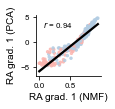

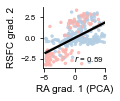

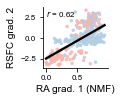

In [14]:
plt.figure(figsize=(1.6,1.5))
sns.regplot(x=nmf_gradients[:,0],y=rsm_gradients[:,0],color='k',scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.ylabel('RA grad. 1 (PCA)',fontsize=10)
plt.xlabel('RA grad. 1 (NMF)',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
rho, p = stats.pearsonr(nmf_gradients[:,0],rsm_gradients[:,0])
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(rho),
             xy=(0.1,.8),fontsize=8,xycoords='axes fraction')
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'RAGradNMF_X_RAGradPCA.pdf',transparent=True)



plt.figure(figsize=(1.6,1.5))
ax = sns.regplot(x=rsm_gradients[:,0],y=parcellated_gradients[:,1],color='k',scatter_kws={'s':6,'color':roiColorsByNetwork,'clip_on':False})
plt.xlabel('RA grad. 1 (PCA)',fontsize=10)
plt.ylabel('RSFC grad. 2',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([-5.2,5])
rho, p = stats.pearsonr(parcellated_gradients[:,1],rsm_gradients[:,0])
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(rho),
             xy=(0.5,.1),fontsize=8,xycoords='axes fraction')
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'RAGradPCA_X_RSGradient2.pdf',transparent=True)

plt.figure(figsize=(1.6,1.5))
ax = sns.regplot(x=nmf_gradients[:,0],y=parcellated_gradients[:,1],color='k',scatter_kws={'s':6,'color':roiColorsByNetwork,'clip_on':False})
plt.xlabel('RA grad. 1 (NMF)',fontsize=10)
plt.ylabel('RSFC grad. 2',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
# plt.xlim([-5.2,5])
rho, p = stats.pearsonr(parcellated_gradients[:,1],nmf_gradients[:,0])
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(rho),
             xy=(0.05,.85),fontsize=8,xycoords='axes fraction')
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'RAGradNMF_X_RSGradient2.pdf',transparent=True)

# Compute the amount of variance explained by first RA component (PCA)

In [15]:
from sklearn.decomposition import PCA

model = PCA(n_components=2)
W = model.fit_transform(rep_dist_mat)
pca_gradients = model.components_.T

print(model.explained_variance_ratio_)

[0.28500378 0.13171023]


# Visualize the 'mean of RA', verify it's not related to first PC

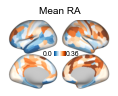

In [18]:
ra_mean = np.mean(rep_dist_mat,axis=0)

vrange = 2
if not os.path.exists(figuredir + 'MeanRA_Vector.png'):
    tmp = np.hstack((ra_mean[180:],ra_mean[:180]))
    tmp = stats.zscore(tmp)
    wbplot.pscalar(figuredir + 'MeanRA_Vector.png',tmp,vrange=(-vrange,vrange),cmap=newcmp)
    
fig = plt.figure(figsize=(1.75,1.75))
ax = plt.subplot(1,1,1)
im = img.imread(figuredir + 'MeanRA_Vector.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Mean RA',fontsize=10)
vmin, vmax = np.min(tmp), np.max(tmp)
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = newcmp
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(np.min(ra_mean),2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
cax.text(1.025, 0.4, str(round(np.max(ra_mean),2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
plt.tight_layout()
# plt.savefig(figuredir + 'MeanRA_Vector_cmap.png',dpi=300,transparent=True)


In [19]:
stats.pearsonr(ra_mean,rsm_gradients[:,0])

(0.5292422079120268, 2.2387334620966725e-27)